In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import sys
sys.path.append("../../../src/")

%matplotlib inline

import nanonets
import nanonets_utils

In [6]:
# Network Parameter
N_electrodes    = 8
N_particles     = 9
N_jumps         = 5000
topology        = {
    "Nx"                : N_particles,
    "Ny"                : N_particles,
    "Nz"                : 1,
    "e_pos"             :  [[0,0,0],[int((N_particles-1)/2),0,0],[N_particles-1,0,0],[0,int((N_particles-1)/2),0],[0,N_particles-1,0],
                            [int((N_particles-1)/2),N_particles-1,0],[N_particles-1,int((N_particles-1)/2),0],[N_particles-1,N_particles-1,0]],
    "electrode_type"    : ['constant','floating','floating','floating','floating','floating','floating','constant']
}
sim_dic         = {
    "error_th"        : 0.0,      
    "max_jumps"       : N_jumps,
    "eq_steps"        : 0,
    "jumps_per_batch" : 1,
    "kmc_counting"    : False,
    "min_batches"     : 1
}
res_info = {
    "mean_R"    : 25.0,
    "std_R"     : 5.0,
    "dynamic"   : False
}

In [7]:
# Voltage Values
N_voltages                  = 1001
U_amplitude                 = 1.0
voltages                    = np.zeros(shape=(N_voltages,N_electrodes+1))
voltages[:,0]               = np.linspace(-U_amplitude, U_amplitude, N_voltages, endpoint=True)
voltages

array([[-1.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [-0.998,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [-0.996,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.996,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.998,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 1.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

In [8]:
target_electrode    = 7
start               = 1000
rename_mapper       = {i-1 : f"$U_{i}$" for i in range(1,N_electrodes-1)}
rename_mapper_np    = {i : f"${i}$" for i in range(N_particles)}
np_index            = N_particles**2//2

min_index   = 450
max_index   = 551

electrode_corr      = {}
electrode_corr2     = {}
nanoparticle_corr   = {}
nanoparticle_corr2  = {}

for seed in range(5):

    sim_class           = nanonets.simulation(network_topology='cubic', topology_parameter=topology, seed=seed, res_info=res_info)
    sim_class.run_const_voltages(voltages=voltages, target_electrode=target_electrode, output_potential=True, verbose=True, sim_dic=sim_dic, save_th=0.1)
    
    output_vals         = pd.DataFrame(sim_class.return_output_values())
    landscape_series    = sim_class.pot_per_it
    electrode_votalges  = {i : pd.DataFrame(landscape_series[i]).iloc[:,:8]*1000 for i in range(N_voltages)}
    time_vals           = {i : np.cumsum(sim_class.time_values[i])*1e9 for i in range(N_voltages)}
    not_finished        = output_vals[output_vals[1] != N_jumps].index

    avg_corr_vals           = pd.DataFrame(np.nanmean([electrode_votalges[i].iloc[start:,1:N_electrodes-1].corr() for i in range(N_voltages) if i not in not_finished], axis=0))
    avg_corr_vals           = avg_corr_vals.rename(columns=rename_mapper, index=rename_mapper)
    electrode_corr[seed]    = avg_corr_vals

    avg_np_corr             = pd.DataFrame(np.mean([np.corrcoef(landscape_series[i][:,N_electrodes:], rowvar=False)[np_index].reshape(N_particles,-1) for i in range(N_voltages) if i not in not_finished], axis=0).reshape(N_particles,-1))
    avg_np_corr             = avg_np_corr.rename(columns=rename_mapper_np, index=rename_mapper_np)
    nanoparticle_corr[seed] = avg_np_corr

    avg_corr_vals           = pd.DataFrame(np.nanmean([electrode_votalges[i].iloc[start:,1:N_electrodes-1].corr() for i in range(N_voltages) if i not in not_finished and i < max_index and i > min_index], axis=0))
    avg_corr_vals           = avg_corr_vals.rename(columns=rename_mapper, index=rename_mapper)
    electrode_corr2[seed]   = avg_corr_vals
    
    avg_np_corr             = pd.DataFrame(np.mean([np.corrcoef(landscape_series[i][:,N_electrodes:], rowvar=False)[np_index].reshape(N_particles,-1) for i in range(N_voltages) if i not in not_finished and i < max_index and i > min_index], axis=0).reshape(N_particles,-1))
    avg_np_corr             = avg_np_corr.rename(columns=rename_mapper_np, index=rename_mapper_np)
    nanoparticle_corr2[seed]= avg_np_corr


## Electrode Correaltion

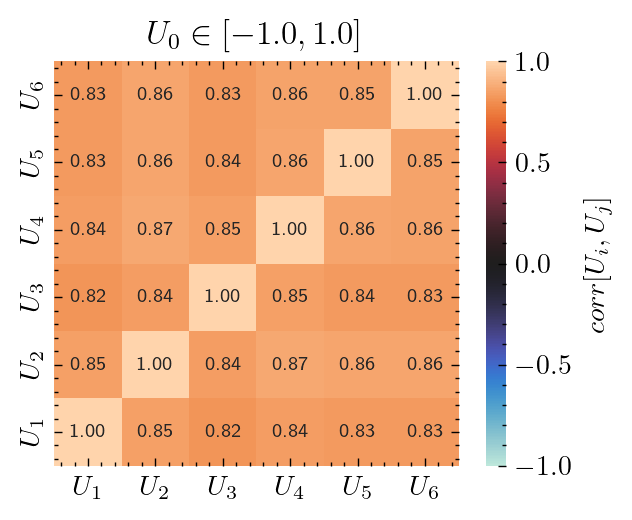

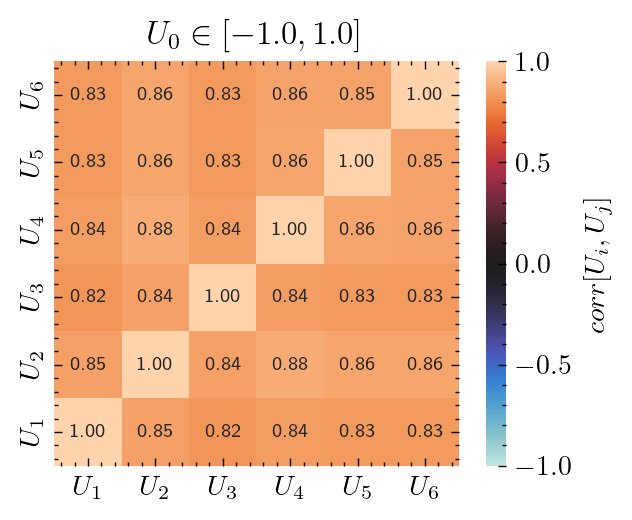

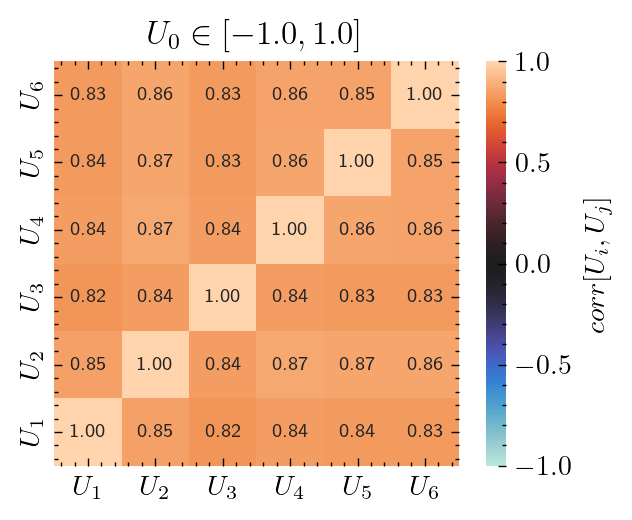

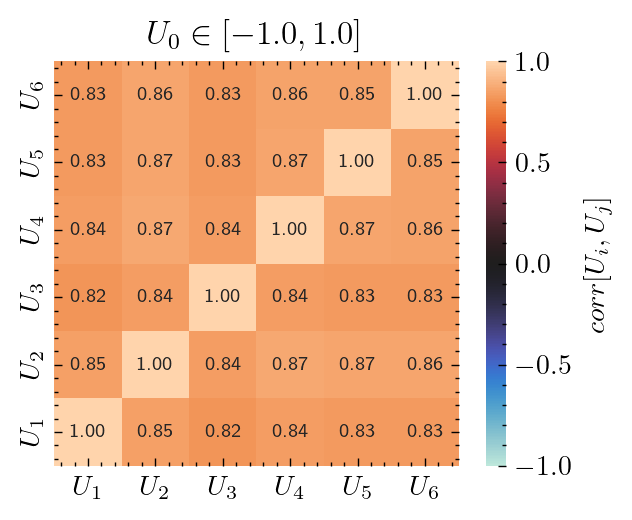

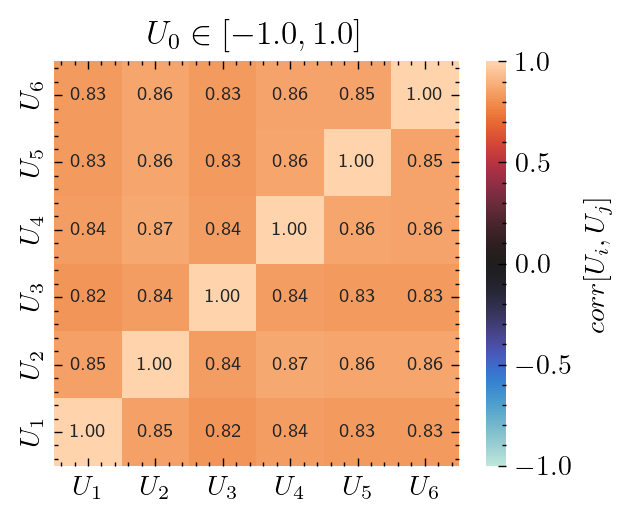

In [9]:
for seed in range(5):

    with plt.style.context(["science","bright"]):

        fig = plt.figure(dpi=200)
        ax  = fig.add_subplot()
        ax  = sns.heatmap(electrode_corr[seed], vmin=-1.0, vmax=1.0, annot=True, fmt='.2f', center=0, square=True, ax=ax, annot_kws={'size':'x-small'}, cbar_kws={'label':'$corr[U_i,U_j]$'})
        ax.set_title(f"$U_0 \in [{round(voltages[0,0],1)},{round(voltages[1000,0],1)}]$")
        ax.invert_yaxis()

        fig.savefig(f"plots/res/electrode_correlation_{seed}.svg", transparent=True)

## NP Correlation

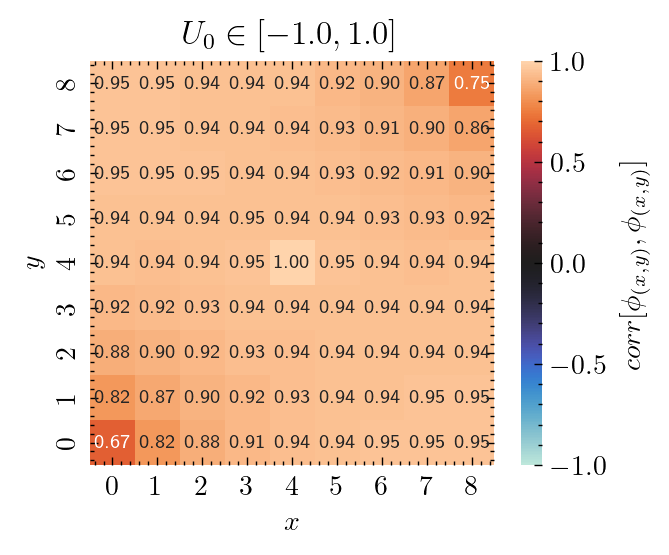

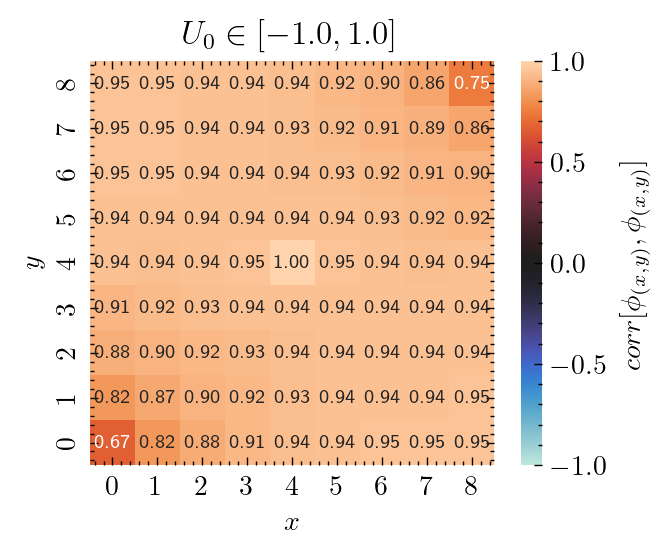

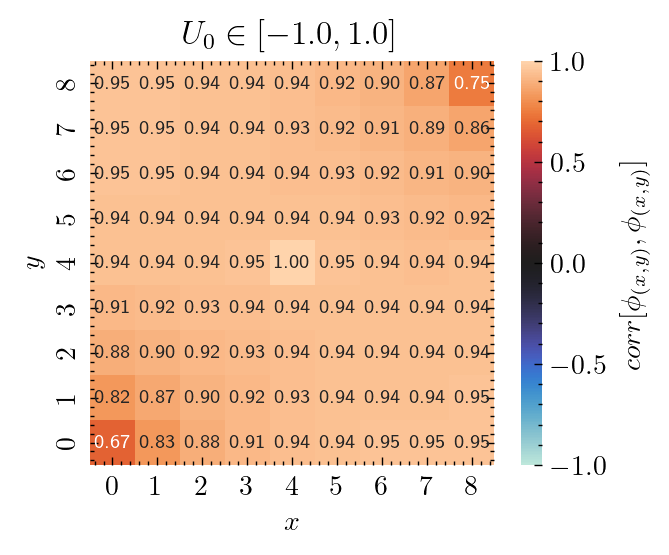

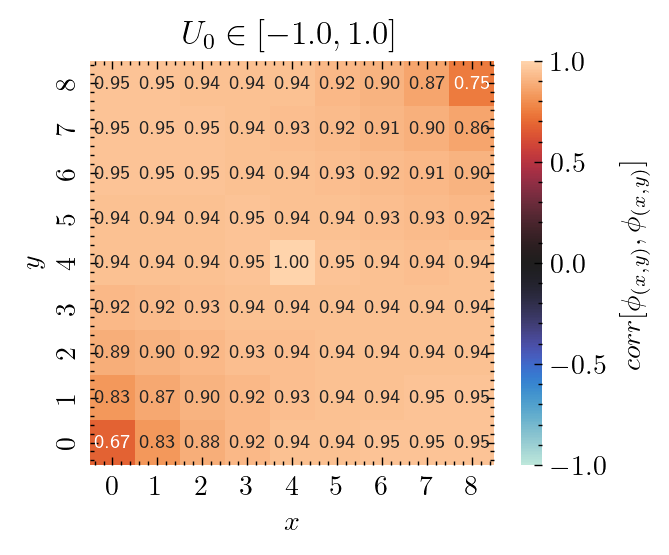

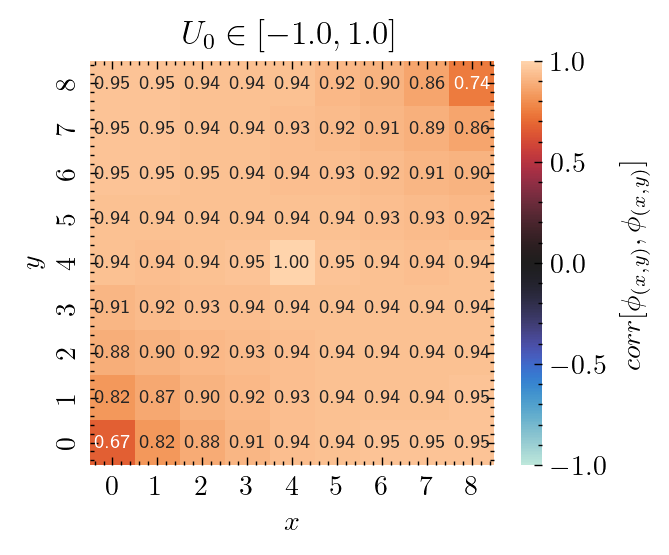

In [10]:
for seed in range(5):

    with plt.style.context(["science","bright"]):

        fig = plt.figure(dpi=200)
        ax  = fig.add_subplot()
        ax  = sns.heatmap(nanoparticle_corr[seed], ax=ax, vmin=-1.0, vmax=1.0, cbar_kws={'label':'$corr[\phi_{(x,y)},\phi_{(x,y)}]$'}, annot=True, fmt='.2f', annot_kws={'size':'x-small'}, center=0, square=True)
        ax.invert_yaxis()
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_title(f"$U_0 \in [{round(voltages[0,0],1)},{round(voltages[1000,0],1)}]$")
        
        fig.savefig(f"plots/res/np_correlation_{seed}.svg", transparent=True)

## Electrode Correaltion close to Blockade

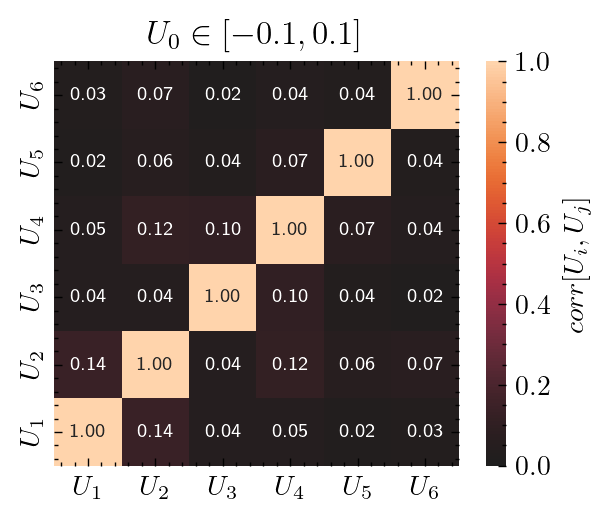

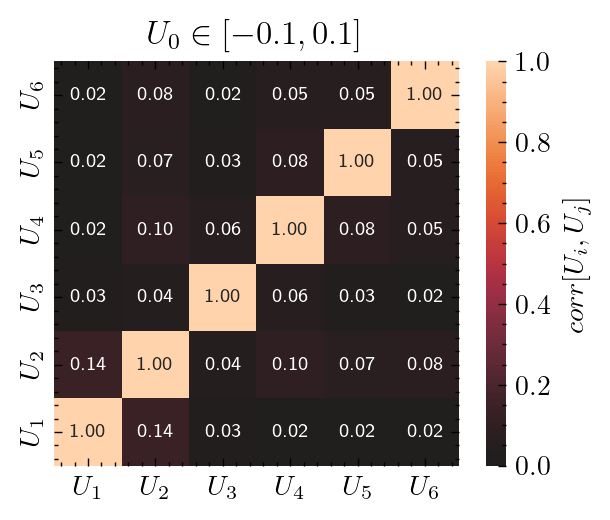

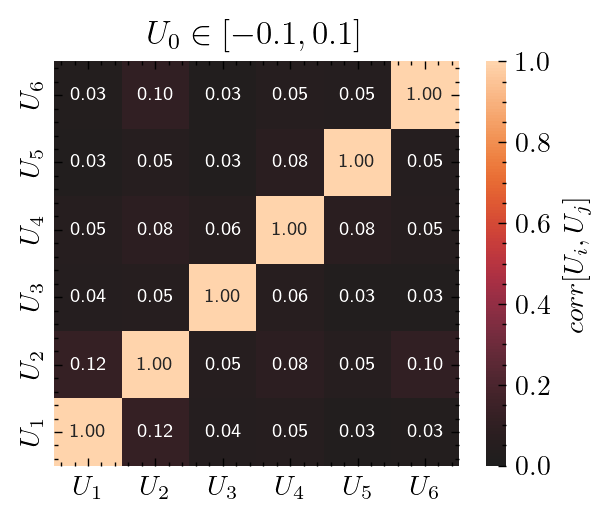

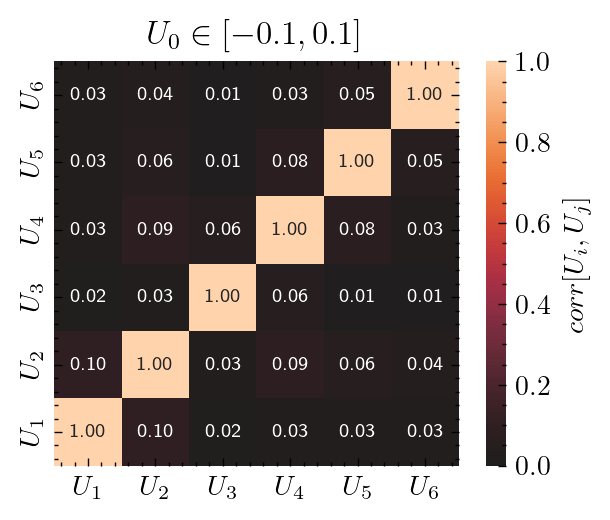

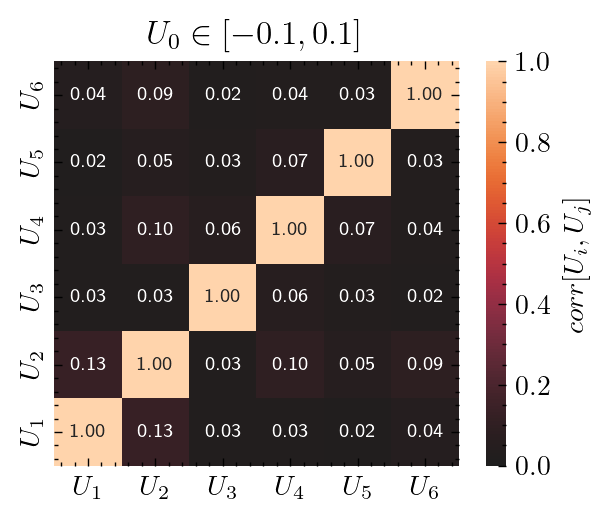

In [11]:
for seed in range(5):

    with plt.style.context(["science","bright"]):

        fig = plt.figure(dpi=200)
        ax  = fig.add_subplot()
        ax  = sns.heatmap(electrode_corr2[seed], vmin=0, vmax=1.0, annot=True, fmt='.2f', center=0, square=True, ax=ax, annot_kws={'size':'x-small'}, cbar_kws={'label':'$corr[U_i,U_j]$'})
        ax.set_title(f"$U_0 \in [{round(voltages[min_index,0],1)},{round(voltages[max_index,0],1)}]$")
        ax.invert_yaxis()
        
        fig.savefig(f"plots/res/electrode_correlation_blockade_{seed}.svg", transparent=True)

## NP Correaltion close to Blockade

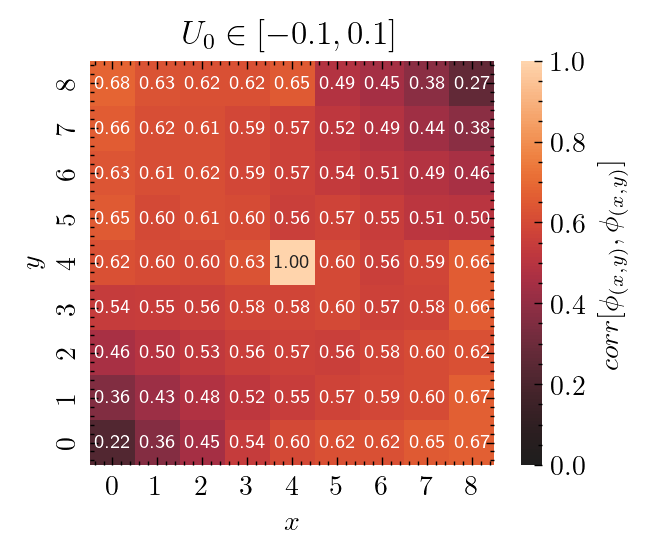

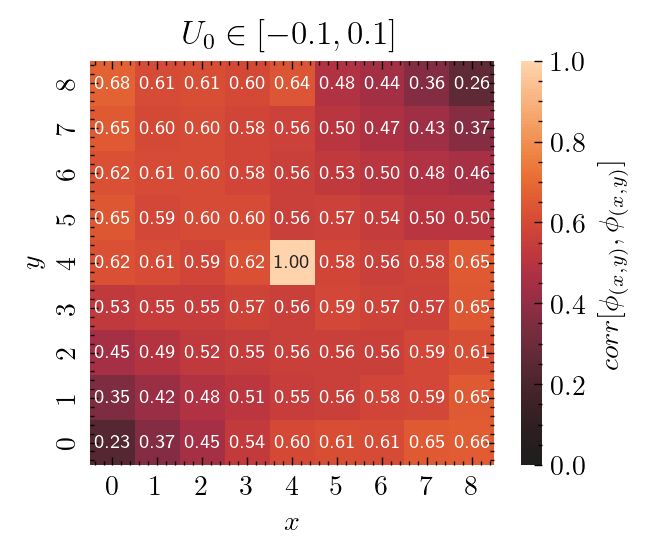

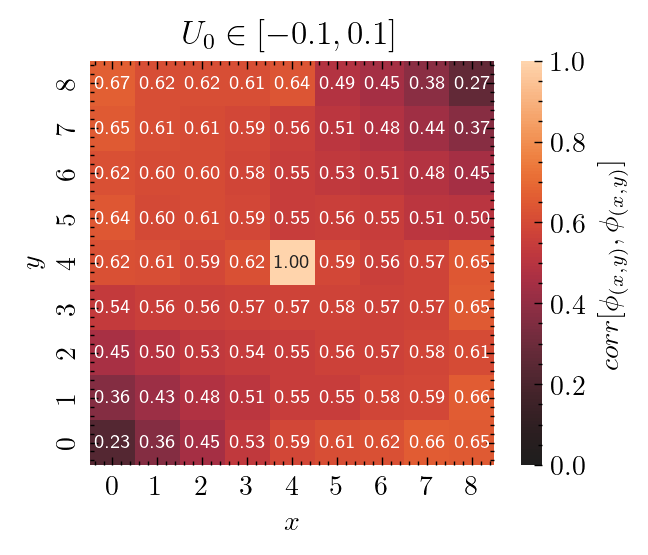

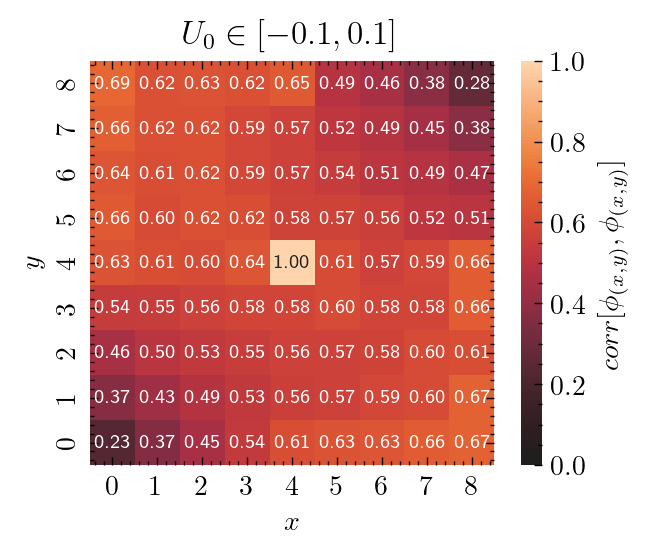

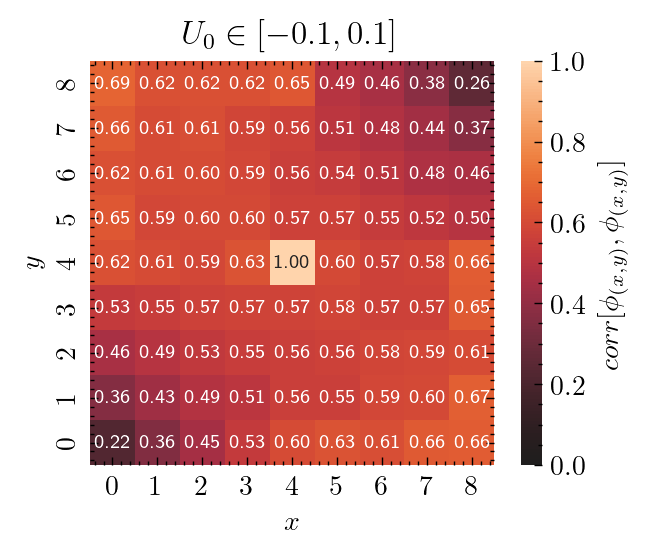

In [12]:
for seed in range(5):

    with plt.style.context(["science","bright"]):

        fig = plt.figure(dpi=200)
        ax  = fig.add_subplot()
        ax  = sns.heatmap(nanoparticle_corr2[seed], ax=ax, vmin=0.0, vmax=1.0, cbar_kws={'label':'$corr[\phi_{(x,y)},\phi_{(x,y)}]$'}, annot=True, fmt='.2f', annot_kws={'size':'x-small'}, center=0, square=True)
        ax.invert_yaxis()
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_title(f"$U_0 \in [{round(voltages[min_index,0],1)},{round(voltages[max_index,0],1)}]$")
        
        fig.savefig(f"plots/res/np_correlation_blockade_{seed}.svg", transparent=True)